In [24]:
import operator
from typing import Annotated, Literal, Optional, Union

from IPython.display import Image, Markdown, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field

In [25]:
llm = ChatOllama(model="qwen2.5")
llm.invoke("Who are you?")

AIMessage(content='I am Qwen, an AI assistant created by Alibaba Cloud. My primary function is to assist users like you with information and tasks, providing help across various topics based on my extensive training. How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-07-12T18:17:47.070649Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1977233375, 'load_duration': 44976875, 'prompt_eval_count': 33, 'prompt_eval_duration': 292960791, 'eval_count': 46, 'eval_duration': 1638626542, 'model_name': 'qwen2.5'}, id='run--4c8da5d8-f302-4bc8-ad4b-c7abb0a3dfe8-0', usage_metadata={'input_tokens': 33, 'output_tokens': 46, 'total_tokens': 79})

In [26]:
class State(BaseModel):
    topic: str = Field(..., description="The topic of the joke")
    joke: Optional[str] = Field(None, description="A joke to be evaluated")
    feedback: Optional[str] = Field(None, description="Feedback from the evaluator")
    funny_or_not: str = Field(None, description="Whether the joke is funny or not")


class Feedback(BaseModel):
    """Feedback model for the evaluator."""

    score: Literal["funny", "not funny"] = Field(
        ..., description="Score given by the evaluator"
    )
    comment: str = Field(..., description="Comment from the evaluator")


evaluator = llm.with_structured_output(Feedback)

In [27]:
class JokeWriter:
    def __init__(self, llm: ChatOllama):
        self.llm = llm

    def __call__(self, state: State) -> dict:
        """Generate a joke evaluation using the LLM."""
        if state.feedback:
            joke = self.llm.invoke(
                SystemMessage(
                    content=(
                        f"Write a joke about {state.topic}. ",
                        f"but take into account the feedback: {state.feedback}",
                    )
                ),
            )
        else:
            joke = self.llm.invoke(
                [SystemMessage(content=f"Write a joke about {state.topic}.")]
            )
        return {"joke": joke.content}


class JokeEvaluator:
    def __init__(self, evaluator: ChatOllama):
        self.evaluator = evaluator

    def __call__(self, state: State) -> dict:
        """Evaluate the joke using the LLM."""
        feedback: Feedback = self.evaluator.invoke(
            [
                SystemMessage(content=f"Evaluate the joke: {state.joke}"),
            ]
        )
        return {"feedback": feedback.comment, "funny_or_not": feedback.score}


def route_joke(state: State) -> str:
    if state.funny_or_not == "funny":
        return "accept_joke"
    elif state.funny_or_not == "not funny":
        return "reject_and_feedback"

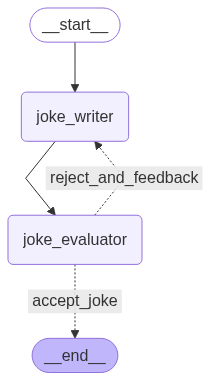

In [28]:
optimizer_builder = StateGraph(State)
optimizer_builder.add_node("joke_writer", JokeWriter(llm))
optimizer_builder.add_node("joke_evaluator", JokeEvaluator(evaluator))

optimizer_builder.add_edge(START, "joke_writer")
optimizer_builder.add_edge("joke_writer", "joke_evaluator")
optimizer_builder.add_conditional_edges("joke_evaluator", route_joke, {
    "accept_joke": END,
    "reject_and_feedback": "joke_writer"
})

optimizer_workflow = optimizer_builder.compile()

display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [29]:
state = optimizer_workflow.invoke({"topic": "Agentic AI systems"})

In [33]:
Markdown(llm.invoke(f"Formmat in markdown: {state}").content)

```markdown
- **topic**: Agentic AI systems
- **joke**: Why did the Agentic AI system refuse to play 2D games?
  
  Because it thought they were too passive and lacked autonomy!
- **feedback**: The joke plays on the idea that an agentic AI, which is designed to act autonomously, would find traditional 2D games unengaging due to their typically passive nature. It's a clever play on the characteristics of both AIs and video games.
- **funny_or_not**: funny
```